<h1> Engineering Numerical Methods, AGH UST</h1>
<h3> Author: Tymoteusz Ciesielski </h3>
<h2> Lab 5 - Poisson equation. Multinet relaxation method </h2>

<h3>Note: Although the solution works, and seems to be correct, there is something wrong in the values of functional integral in calculate_stop_sum() function.</h3>

In [311]:
from math import sin, pi, fabs
import numpy as np
import pandas as pd

#plotting
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

1. All the calculations are made in one potential array - the densest one. We just use one k parameter for steps.
2. Boundary conditions are set only once- before starting the relaxation method for the sparsest grid - in my case, during initialisation with set_boundary_elements() function.
3. After stabilisation of the solution for index k, we dense the net - in new, red nodes we set the interpolated values (what values?) - it is gonna be the starting potential for relaxation method in denser grid, as it is quite good approximation of the correct solution.  

In [312]:
class Multinet_relaxation_method:

    #generating meshgrid 
    def __init__(self):
        self.delta = 0.2
        self.n_x = 128
        self.n_y = 128
        self.x_max = self.delta*self.n_x
        self.y_max = self.delta*self.n_y
        self.TOL = 1e-8
        self.potential_values = np.zeros((self.n_x + 1, self.n_y + 1))
        self.set_boundary_elements()
        self.max_iterations = 160
        self.stop_sums = np.zeros(self.max_iterations+1)
    
    def set_boundary_elements(self):
        for y in range(self.n_y):
            self.potential_values[0, y] = + sin( pi*self.delta*y/self.y_max )
            self.potential_values[-1, y] = + sin( pi*self.delta*y/self.y_max )
        for x in range(self.n_x):
            self.potential_values[x, -1] = - sin(2*pi*self.delta*x/self.x_max)
            self.potential_values[x, 0] = + sin(2*pi*self.delta*x/self.x_max)
        
    def solve(self, k):
        self.stop_sums[0] = self.calculate_stop_sum(k)
        
        for iteration in range(self.max_iterations):
            print("Iteration {}".format(iteration))
            for x in range(k, self.n_x, k):
                for y in range(k, self.n_y , k):
                    #print("L = {} R = {} U = {} D = {}".format(self.potential_values[x-k,y], self.potential_values[x+k,y], \
                    #                                 self.potential_values[x,y+k], self.potential_values[x,y-k]) )
                                                                                                                   
                    self.potential_values[x,y] = 1/4*(self.potential_values[x+k,y] + self.potential_values[x-k,y] + \
                                                 self.potential_values[x,y+k] + self.potential_values[x,y-k])
                    #print("Value of x={} y={} is {}".format(x,y,self.potential_values[x,y]) )
                    
            self.stop_sums[iteration+1] = self.calculate_stop_sum(k)
            if fabs((self.stop_sums[iteration+1] - self.stop_sums[iteration])/self.stop_sums[iteration]) < self.TOL:
                print("**********")
                print("Iteration {} Solution stable for k={} and TOL={}".format(iteration, k, self.TOL))
                break
            else:
                continue
                
    def make_denser(self,k):
        half = int(k/2)
        for x in range(k, self.n_x, k):
            for y in range(k, self.n_y, k):
               
                self.potential_values[x+half, y+half] = 1/4*(self.potential_values[x,y] + self.potential_values[x+k,y] + self.potential_values[x,y+k] + self.potential_values[x+k,y+k])
                self.potential_values[x+k, y+half] = 1/2*(self.potential_values[x+k,y] + self.potential_values[x+k, y+k])
                self.potential_values[x+half, y+half] = 1/2*(self.potential_values[x,y+k] + self.potential_values[x+k, y+k])
                self.potential_values[x+half, y] = 1/2 * (self.potential_values[x,y] + self.potential_values[x+k, y])
                self.potential_values[x,y+half] = 1/2 * (self.potential_values[x,y] + self.potential_values[x, y+k])
        
    def save_to_file(self,k):
        with open("Stop_sums_k_{}_v2.txt".format(k), 'w' ) as data_file:
            i=0
            for sum in self.stop_sums:
                data_file.write("{} {}\n".format(i, sum))
                i+=1
    
    def save_sums(self):
        array = self.stop_sums.copy()
        return array
    
    def calculate_stop_sum(self, k):
        # calculating the value of functional integral of the net
        # it is used to compare between iterations, as a Stop condition for the given tolerance
        sum = 0
        for i in range(self.n_x - k):
            for j in range(self.n_y - k):
                sum += (k*self.delta)**2/2 * \
                (
                  ( (self.potential_values[i+k, j] - self.potential_values[i, j]) /(2*k*self.delta) +  (self.potential_values[i+k,j+k]-self.potential_values[i,j+k])/(2*k*self.delta) )**2\
                + ( (self.potential_values[i,j+k]-self.potential_values[i,j])/(2*k*self.delta) +  (self.potential_values[i+k, j+k] - self.potential_values[i+k,j])/(2*k*self.delta) )**2 \
                )
#         for i in range(self.n_x - k):
#             for j in range(self.n_y - k):
#                 sum += (k*self.delta)**2/2 / (2*k*self.delta)**2 * \
#                 (\
#                  (self.potential_values[i+k,j] - self.potential_values[i,j] + self.potential_values[i+k,j+k] - self.potential_values[i,j+k])**2 \
#                  + (self.potential_values[i,j+k] - self.potential_values[i,j] + self.potential_values[i+k,j+k] - self.potential_values[i+k,j])**2
#                 )
        
        return sum
                 

<h1> Initialising our grid and setting the boundary values </h1>

In [313]:
net1 = Multinet_relaxation_method()

<h1> Solution for k = 16 </h1>

In [314]:
net1.solve(16)
net1.save_to_file(16)

sums1 = net1.save_sums()
net1.make_denser(16)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
**********
Iteration 63 Solution stable for k=16 and TOL=1e-08


<h2>Plotting potential values </h2>

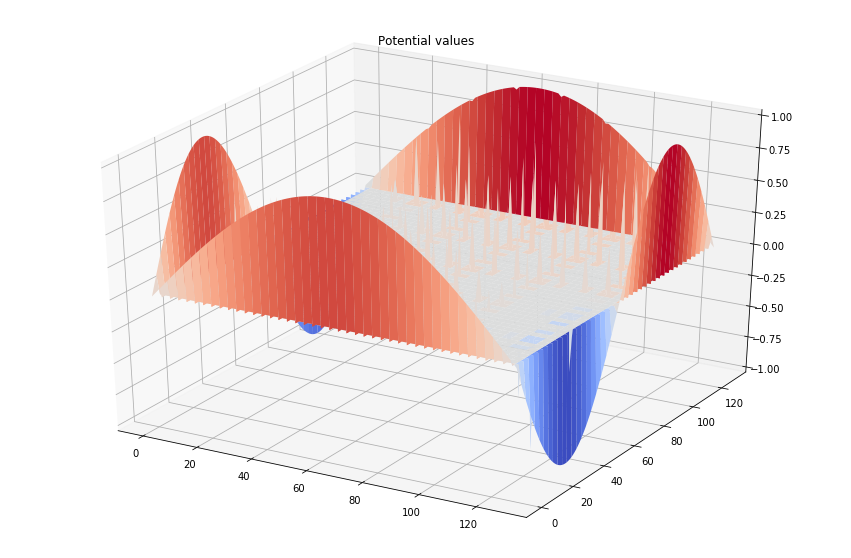

In [315]:
#
y = np.arange(0, net1.n_x + 1 )
x = np.arange(0, net1.n_y + 1)

X,Y = np.meshgrid( x, y )

figure = plt.figure(figsize=(15,10))
figure_extended = figure.add_subplot(111, projection='3d')

figure_extended.plot_surface(X,Y, net1.potential_values, cmap=cm.coolwarm)
plt.title("Potential values")
#plt.plot(first.V_old)
plt.show()

In [316]:
# plt.figure(figsize=(net1.n_x+1, net1.n_y+1))
# color_map = plt.imshow(net1.potential_values)
# color_map.set_cmap(cm.coolwarm)

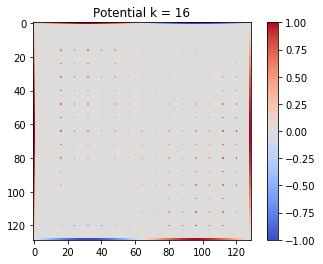

In [317]:
plt.title("Potential k = 16")
plt.xlabel=('x axis')
plt.ylabel=('y axis')

plt.imshow(np.transpose((net1.potential_values)), cmap=cm.coolwarm, interpolation='nearest')

plt.colorbar()
plt.show()

<h1> Solution for k = 8 </h1>

In [318]:
net1.solve(8)
net1.save_to_file(8)

sums2 = net1.save_sums()
net1.make_denser(8)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [319]:
# plt.figure(figsize=(net1.n_x+1, net1.n_y+1), dpi=70)
# color_map = plt.imshow(net1.potential_values)
# color_map.set_cmap(cm.coolwarm)

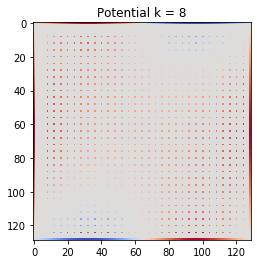

In [320]:
plt.title("Potential k = 8")
# plt.xlabel=('x axis')
# plt.ylabel=('y axis')

plt.imshow(np.transpose((net1.potential_values)), cmap=cm.coolwarm, interpolation='nearest')

#plt.colorbar()
plt.show()

<h1> Solution for k = 4 </h1>

In [322]:
net1.solve(4)
net1.save_to_file(4)

sums3 = net1.save_sums()
net1.make_denser(4)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [323]:
# plt.figure(figsize=(net1.n_x+1, net1.n_y+1))
# color_map = plt.imshow(net1.potential_values)
# color_map.set_cmap(cm.coolwarm)

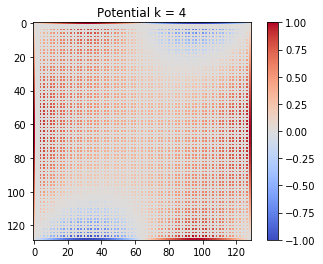

In [324]:
plt.title("Potential k = 4")
plt.xlabel=('x axis')
plt.ylabel=('y axis')

plt.imshow(np.transpose(net1.potential_values), cmap=cm.coolwarm, interpolation='nearest')

plt.colorbar()
plt.show()

<h1> Solution for k = 2 </h1>

In [325]:
net1.solve(2)
net1.save_to_file(2)

sums4 = net1.save_sums()
net1.make_denser(2)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [326]:
# plt.figure(figsize=(net1.n_x+1, net1.n_y+1))
# color_map = plt.imshow(net1.potential_values)
# color_map.set_cmap(cm.coolwarm)

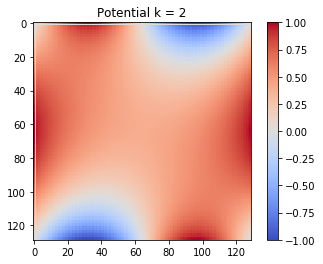

In [327]:
plt.title("Potential k = 2")
plt.xlabel=('x axis')
plt.ylabel=('y axis')

plt.imshow(np.transpose((net1.potential_values)), cmap=cm.coolwarm, interpolation='nearest')

plt.colorbar()
plt.show()

<h1> Solution for k = 1 </h1>

In [328]:
net1.solve(1)
net1.save_to_file(1)

sums5 = net1.save_sums()
net1.make_denser(1)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [329]:
# plt.figure(figsize=(net1.n_x+1, net1.n_y+1))
# color_map = plt.imshow(net1.potential_values)
# color_map.set_cmap(cm.coolwarm)

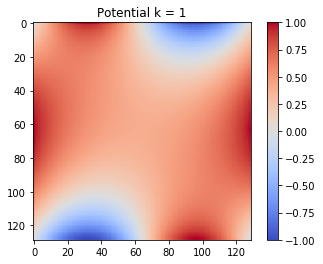

In [330]:
plt.title("Potential k = 1")
plt.xlabel=('x axis')
plt.ylabel=('y axis')

plt.imshow(np.transpose((net1.potential_values)), cmap=cm.coolwarm, interpolation='nearest')

plt.colorbar()
plt.show()

<h1> Some additional handy stuff </h1>

In [331]:
df = pd.DataFrame(net1.potential_values)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

display(df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,0.000000e+00,0.024541,0.049068,0.073565,0.098017,0.122411,0.146730,0.170962,0.195090,0.219101,0.242980,0.266713,0.290285,0.313682,0.336890,0.359895,0.382683,0.405241,0.427555,0.449611,0.471397,0.492898,0.514103,0.534998,0.555570,0.575808,0.595699,0.615232,0.634393,0.653173,0.671559,0.689541,0.707107,0.724247,0.740951,0.757209,0.773010,0.788346,0.803208,0.817585,0.831470,0.844854,0.857729,0.870087,0.881921,0.893224,0.903989,0.914210,0.923880,0.932993,0.941544,0.949528,0.956940,0.963776,0.970031,0.975702,0.980785,0.985278,0.989177,0.992480,0.995185,0.997290,0.998795,0.999699,1.000000,0.999699,0.998795,0.997290,0.995185,0.992480,0.989177,0.985278,0.980785,0.975702,0.970031,0.963776,0.956940,0.949528,0.941544,0.932993,0.923880,0.914210,0.903989,0.893224,0.881921,0.870087,0.857729,0.844854,0.831470,0.817585,0.803208,0.788346,0.773010,0.757209,0.740951,0.724247,0.707107,0.689541,0.671559,0.653173,0.634393,0.615232,0.595699,0.575808,0.555570,0.534998,0.514103,0.492898,0.471397,0.449611,0.427555,0.405241,0.382683,0.359895,0.336890,0.313682,0.290285,0.266713,0.242980,0.219101,0.195090,0.170962,0.146730,0.122411,0.098017,0.073565,0.049068,0.024541,-0.000000e+00
1,4.906767e-02,0.106264,0.127033,0.147904,0.168855,0.189866,0.210916,0.231986,0.253056,0.274106,0.295118,0.316073,0.336952,0.357738,0.378411,0.398955,0.419352,0.439586,0.459639,0.479495,0.499139,0.518554,0.537725,0.556637,0.575276,0.593626,0.611674,0.629406,0.646809,0.663870,0.680575,0.696913,0.712871,0.728438,0.743602,0.758352,0.772678,0.786568,0.800013,0.813004,0.825530,0.837584,0.849155,0.860236,0.870818,0.880895,0.890459,0.899502,0.908018,0.916002,0.923446,0.930346,0.936696,0.942492,0.947729,0.952402,0.956509,0.960046,0.963009,0.965396,0.967205,0.968434,0.969081,0.969145,0.968625,0.967521,0.965831,0.963558,0.960700,0.957259,0.953236,0.948632,0.943450,0.937692,0.931359,0.924456,0.916985,0.908949,0.900352,0.891199,0.881494,0.871242,0.860447,0.849115,0.837251,0.824862,0.811953,0.798530,0.784601,0.770172,0.755250,0.739843,0.723957,0.707602,0.690784,0.673513,0.655796,0.637642,0.619059,0.600057,0.580645,0.560832,0.540626,0.520039,0.499078,0.477754,0.456077,0.434056,0.411702,0.389023,0.366029,0.342732,0.319139,0.295261,0.271108,0.246689,0.222012,0.197089,0.171926,0.146534,0.120920,0.095093,0.069061,0.042832,0.016413,-0.010189,-0.036966,-0.063913,-4.906767e-02
2,9.801714e-02,0.155775,0.173912,0.192247,0.210753,0.229408,0.248186,0.267064,0.286019,0.305028,0.324069,0.343120,0.362158,0.381164,0.400117,0.418996,0.437782,0.456455,0.474997,0.493389,0.511613,0.529651,0.547487,0.565103,0.582484,0.599613,0.616474,0.633054,0.649337,0.665309,0.680957,0.696266,0.711224,0.725818,0.740036,0.753866,0.767297,0.780317,0.792915,0.805082,0.816808,0.828082,0.838895,0.849240,0.859106,0.868486,0.877373,0.885758,0.893635,0.900998,0.907839,0.914153,0.919934,0.925177,0.929878,0.934032,0.937634,0.940682,0.943170,0.945098,0.946461,0.947258,0.947487,0.947146,0.946233,0.944748,0.942690,0.940060,0.936856,0.933080,0.928732,0.923813,0.918325,0.912270,0.905648,0.898464,0.890718,0.882415,0.873557,0.864148,0.854191,0.843691,0.832652,0.821078,0.808973,0.796344,0.783196,0.769533,0.755361,0.740686,0.725515,0.709853,0.693707,0.677084,0.659989,0.642431,0.624416,0.605951,0.587044,0.567702,0.547932,0.527743,0.507141,0.486134,0.464730,0.442936,0.420761,0.398212,0.375296,0.352021,0.328393,0.304421,0.280111,0.255469,0.230503,0.205217,0.179618,0.153712,0.127503,0.100996,0.074195,0.047103,0.019724,-0.007939,-0.035884,-0.064110,-0.092617,-0.112551,-9.801714e-02
3,1.467305e-01,0.198254,0.213766,0.229577,0.245658,0.261980,0.278515,

<h2> Plotting the intergral values</h2>

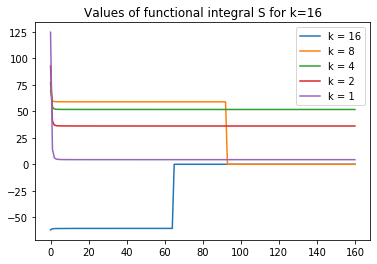

In [332]:
iter_tab = np.arange(net1.max_iterations+1)
sums1.shape
iter_tab.shape

sums1 = -sums1
plt.figure(0)
plt.title(label= "Values of functional integral S for k=16")
# plt.plot(iter_tab[1:], sums1[1:], label="k = 16")
# plt.plot(iter_tab[1:], sums2[1:], label="k = 8")
# plt.plot(iter_tab[1:], sums3[1:], label="k = 4")
# plt.plot(iter_tab[1:], sums4[1:], label="k = 2")
# plt.plot(iter_tab[1:], sums5[1:], label ="k = 1")
plt.plot(iter_tab[0:], sums1[0:], label="k = 16")
plt.plot(iter_tab[0:], sums2[0:], label="k = 8")
plt.plot(iter_tab[0:], sums3[0:], label="k = 4")
plt.plot(iter_tab[0:], sums4[0:], label="k = 2")
plt.plot(iter_tab[0:], sums5[0:], label ="k = 1")
plt.legend()
plt.show()